In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import ipyparallel as ipp
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from string import punctuation
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from nltk.tokenize import RegexpTokenizer
from afinn import Afinn
from numpy.linalg import norm
from pandas.io.json import json_normalize
from fuzzywuzzy import fuzz
from collections import defaultdict
from sklearn.manifold import TSNE
from datetime import datetime

In [2]:
# Removes stop words.
def text_tokens(tweets,text_parse):
    
    tweet_tokens = []
    
    for tweet in tweets:
        
        token_list = []
        tokens = tknzr.tokenize(tweet)
        
        for token in tokens:
            
            token_value=token.lower()
            
            if token_value not in text_parse:
                
                token_list.append(token_value)
        
        tweet_tokens.append(token_list)
    
    return tweet_tokens

In [3]:
def sentiment(tokens):
    
    af = Afinn()
    
    return [af.score(' '.join(tweet)) for tweet in tokens]

In [4]:
# Creates vocabulary.
def vocab_build(token_list):
    
    vocab = defaultdict()
    vocab.default_factory = vocab.__len__
    
    for tokens in token_list:
        
        for word in tokens:
            
            vocab[word]
    
    return vocab

In [5]:
def get_word_embeddings(filename,vocab):
    
    fh = open(filename,'r',buffering=4096,encoding='UTF-8')
    
    word_embeddings = {}
    
    for line in fh:
        
        vec = line.split()
        
        if vec[0] in vocab:
            
            word_embeddings[vec[0]] = np.asarray(vec[1:],dtype=np.float32)
    
    return word_embeddings

In [6]:
def embed_vecs(token_list,word_embeddings):
    
    embedded_vecs = np.array([sum([word_embeddings.get(word,np.zeros(300,)) for word in tokens])/len(tokens) for \
                tokens in token_list])
    
    return embedded_vecs

In [7]:
def tweet_norms(tweet_vecs):
    
    norm_vecs = []
    
    for vec in tweet_vecs:
        
        norm_vecs.append(norm(vec))
    
    norm_vecs = np.array(norm_vecs)
    norm_vecs[np.isinf(norm_vecs)] = 0
    norm_vecs[np.isnan(norm_vecs)] = 0
    
    return norm_vecs

In [8]:
def embedded_cos_distance(tweet_vecs):
    
    tweets = []
    
    for idx,tweet in enumerate(tweet_vecs):
        
        distance = np.mean(tweet_vecs.dot(tweet)/np.sqrt(vec_norms[idx]*vec_norms))
        tweets.append([distance])
    
    tweets = np.array(tweets)
    tweets[np.isinf(tweets)] = 0
    tweets[np.isnan(tweets)] = 0
    
    return np.array(tweets)

In [9]:
def get_pos_tags(token_list):
    
    pos_tags = []
    
    for tokens in token_list:
        
        tags = nlp(' '.join(tokens))
        
        for token in tags:
            
            pos_tags.append(token.pos_)

    return pos_tags

In [10]:
def pos(tweets):
    
    text_pos = []
    
    for tweet in tweets:
        
        tags = []
        nlp_tags = nlp(' '.join(tweet))
        
        for token in nlp_tags:
            
            tags.append(token.pos_)
        
        tags = np.array(tags)
        current_tags = {}
        
        for tag in total_tags:
            
            current_tags[tag] = len(tags[tags==tag])
        
        text_pos.append(current_tags)
    
    return text_pos

In [11]:
def vec_diff(tweet_vecs):
    
    delta_vecs = []
    
    for idx,vec in enumerate(tweet_vecs):
        
        delta_vecs.append([np.sum(np.mean(np.abs(tweet_vecs - vec),axis=0))])
    
    return np.array(delta_vecs)

In [12]:
def edit_distance(tokens):
    
    avg_edit_distance = []
    delim = ','
    
    for token in tokens:
        
        edit = []
        text = delim.join(token)
        
        for token_compare in token_list:
            
            text_compare = delim.join(token_compare)
            edit.append(fuzz.ratio(text,text_compare))
        
        avg_edit_distance.append([np.mean(np.array(edit))])
    
    return np.array(avg_edit_distance)

In [13]:
def get_entity_list(tweets):
    
    entity_list = []
    
    for tweet in tweets:
        
        for ent in nlp(tweet).ents:
                
            entity_list.append(ent.label_)
    
    return entity_list

In [14]:
def entity(tweets):
   
    entities = []
    
    for tweet in tweets:
        
        current_entity = {}
        current_entities = []
        
        for ent in nlp(tweet).ents:
            
            current_entities.append(ent.label_)
        
        current_entities = np.array(current_entities)
        
        for ent in total_entity_list:
            
            current_entity[ent] = len(current_entities[current_entities==ent])
        
        entities.append(current_entity)
    
    return entities

In [15]:
def feature_generation(df,stop_words,tknzr,nlp):
    
    client = ipp.Client()
    dview = client[:]
    
    with dview.sync_imports():
        
        import numpy
        from afinn import Afinn
        from pandas.io.json import json_normalize
        from fuzzywuzzy import fuzz
        from warnings import filterwarnings
    
    %px np = numpy
    %px norm = numpy.linalg.norm
    %px filterwarnings('ignore','elementwise')
    
    print('\n')
    print('Getting tokens')
    
    time = datetime.now()
    
    tweets = df.text.values
    
    dview.push({'tknzr':tknzr,'text_parse':stop_words,'text_tokens':text_tokens})
    dview.scatter('text',tweets)
    %px tokens = text_tokens(text,text_parse)
    tokens = sum(dview['tokens'],[])
    
    df['tokens'] = tokens
    df = pd.DataFrame(df.values,columns=df.columns,index=list(range(len(df))))
    token_idx = [idx for idx,token in enumerate(tokens) if len(token) == 0]
    df = df.drop(token_idx,axis=0)
    
    columns = df.columns
    idx = list(range(len(df)))
    df = pd.DataFrame(df.values,index=idx,columns=columns)
    
    tokens = df.tokens.values
    tweets = df.text.values
    df[['text']].to_csv('text/train_text.csv')
    dview.scatter('tokens',tokens)
    dview.scatter('text',tweets)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Getting sentiment')
    
    time = datetime.now()
    
    dview.push({'sentiment':sentiment})
    %px tweet_sentiments = sentiment(tokens)
    
    df['sentiment'] = sum(dview['tweet_sentiments'],[])
    
    print(datetime.now()-time)
    print('\n')
    
    df['daily_diff'] = df.close-df.open
    
    print('Tagging parts of speech')
    
    time = datetime.now()
    
    dview.push({'get_pos_tags':get_pos_tags,'nlp':nlp})
    %px pos_tags = get_pos_tags(tokens)
    total_tags = set(sum(dview['pos_tags'],[]))
    fh = open('./pos_tags/train_pos.csv','w')
    for tag in total_tags:
        fh.write(tag + '\n')
    fh.close()
    dview.push({'total_tags':total_tags})
    
    dview.push({'pos':pos})
    %px pos_tags = pos(tokens)
    pos_tags = json_normalize(sum(dview['pos_tags'],[]))
    df = pd.concat([df,pos_tags],axis=1)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Tagging entities')
    
    time = datetime.now()
    
    dview.push({'get_entity_list':get_entity_list})
    %px entities = get_entity_list(text)
    total_entity_list = set(sum(dview['entities'],[]))
    fh = open('./entities/train_entities.csv','w')
    for ent in total_entity_list:
        fh.write(ent + '\n')
    fh.close()
    dview.push({'total_entity_list':total_entity_list})
    
    dview.push({'entity':entity})
    %px entities = entity(text)
    entities = json_normalize(sum(dview['entities'],[]))
    df = pd.concat([df,entities],axis=1)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Building vocab')
    
    time = datetime.now()
    
    vocab = vocab_build(tokens)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Getting word embeddings')
    
    time = datetime.now()
    
    word_embeddings = get_word_embeddings('../glove.6B.300d.txt',vocab)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Embedding tweet vecs')
    
    time = datetime.now()
    
    dview.push({'embed_vecs':embed_vecs,'word_embeddings':word_embeddings})
    %px embedded_vecs = embed_vecs(tokens,word_embeddings)
    embedded_vecs = np.concatenate(dview['embedded_vecs'],axis=0)
    df_embedded_vecs = pd.DataFrame(embedded_vecs,columns=range(embedded_vecs.shape[1]))
    df_embedded_vecs.to_csv('./embedded_vecs/train_embedded_vecs.csv')
    
    print(datetime.now()-time)
    print('\n')
    
    print('Calculating norms')
    
    time = datetime.now()
    
    dview.push({'tweet_norms':tweet_norms})
    %px vec_norms = tweet_norms(embedded_vecs)
    vec_norms = np.concatenate(dview['vec_norms'],axis=0)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Calculating cosine distance')
    
    time = datetime.now()
    
    dview.push({'embedded_cos_distance':embedded_cos_distance})
    %px cos_vecs = embedded_cos_distance(embedded_vecs)
    cos_vecs = np.concatenate(dview['cos_vecs'],axis=0)
    
    print(datetime.now()-time)
    print('\n')
    
    print('Calculating vec difference')
    
    time = datetime.now()
    
    dview.push({'vec_diff':vec_diff})
    %px delta_vecs = vec_diff(embedded_vecs)
    delta_vecs = np.concatenate(dview['delta_vecs'],axis=0)
    
    print(datetime.now()-time)
    print('\n')
    
    df['vec_norms'] = vec_norms
    df[['vec_norms']].to_csv('./embedded_vec_norms/train_norms.csv',columns=['vec_norms'])
    df['cos_vecs'] = cos_vecs
    df['delta_vecs'] = delta_vecs
    df = pd.concat([df,df_embedded_vecs],axis=1)
    
    df['up_down'] = [1 if diff > 0 else 0 for diff in df.daily_diff]
    
    cols = ['close','date','high','low','open','user.screen_name','text','ticker','time','tokens',\
            'contributors_enabled','favorited','daily_diff','volume']
    df = df.drop(cols,axis=1)
    df.to_csv('./train_data/train_data.csv',columns=df.columns)
    
    return df,word_embeddings

In [16]:
def feature_correlation(df):
    
    rows = len(df)
    columns = list(df.columns)
    col_idx = [idx for idx,col in enumerate(columns) if isinstance(col,int) == True]
    features = df.values[:,:col_idx[0]]
    cols = features.shape[1]
    correlation = np.zeros((cols,cols))
    for col in range(cols):
        num = np.mean((features-features.mean(axis=0))*(features[:,col]-features[:,col].mean(axis=0))\
                      .reshape(rows,1),axis=0)
        denom = features[:,col].std()*features.std(axis=0,dtype=float)
        feature_corr = num/denom
        correlation[col] = feature_corr
    corr_cols = df.columns[:col_idx[0]]
    corr_cols_idx = range(cols)
    df_corr = pd.DataFrame(correlation,columns=corr_cols,index=corr_cols)
    fig,ax = plt.subplots()
    fig.set_size_inches(40,40)
    ax.imshow(correlation)
    ax.set_xticks(corr_cols_idx)
    ax.set_yticks(corr_cols_idx)
    ax.set_xticklabels(corr_cols)
    ax.set_yticklabels(corr_cols)
    plt.setp(ax.get_xticklabels(),fontsize=32, rotation=90)
    plt.setp(ax.get_yticklabels(),fontsize=32)
    plt.show()

    return df_corr,ax

In [17]:
def feature_target_correlation(df):
    
    features = df.values[:,:-1]
    targets = df.values[:,-1].reshape(len(features),1)
    num = np.mean((features-features.mean(axis=0))*(targets-targets.mean(axis=0)),axis=0)
    denom = features.std(axis=0,dtype=float)*targets.std(axis=0,dtype=float)
    correlation = num/denom
    df = pd.DataFrame(correlation,index=df.columns[:-1],columns=['Target Correlation'])
    df = df.sort_values(df.columns[0],axis=0,ascending=False)
    
    return df

In [57]:
def word_plot(word_embeddings):
    
    words = list(word_embeddings.keys())
    X = np.array(list(word_embeddings.values()))
    tsne = TSNE(2)
    x_tsne = tsne.fit_transform(X)
    fig,ax = plt.subplots()
    fig.set_size_inches(40,40)
    ax.scatter(x_tsne[:50,0],x_tsne[:50,1])
    for idx,word in enumerate(words[:50]):
        x = x_tsne[idx,0]
        y = x_tsne[idx,1]
        plt.annotate(word,xy=(x,y),xytext=(x+1,y+1),textcoords='offset points',fontsize=28)
    plt.show()
    return ax

In [19]:
nlp = spacy.load('../twitter/en_core_web_sm-2.1.0/en_core_web_sm/en_core_web_sm-2.1.0')

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
tknzr = RegexpTokenizer('[a-zA-Z]+')

In [22]:
punctuation_parse = [mark for mark in punctuation]
word_parse = stopwords.words('english')
stop_words = punctuation_parse + word_parse

In [23]:
df = pd.read_json('../twitter/twitter_stock_data.json')

In [24]:
time = datetime.now()
df_features,word_embeddings = feature_generation(df,stop_words,tknzr,nlp)
print('Total time: ',datetime.now()-time)

importing numpy on engine(s)
importing Afinn from afinn on engine(s)
importing json_normalize from pandas.io.json on engine(s)
importing fuzz from fuzzywuzzy on engine(s)
importing filterwarnings from warnings on engine(s)


Getting tokens
0:00:15.008108


Getting sentiment
0:00:39.016062


Tagging parts of speech
0:38:41.438584


Tagging entities
0:44:15.527395


Building vocab
0:00:00.668486


Getting word embeddings
0:00:12.962763


Embedding tweet vecs
0:02:40.623844


Calculating norms
0:00:00.867952


Calculating cosine distance


[stderr:3] /usr/local/anaconda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


0:39:06.428651


Calculating vec difference
5:01:08.631294


Total time:  7:09:50.607532


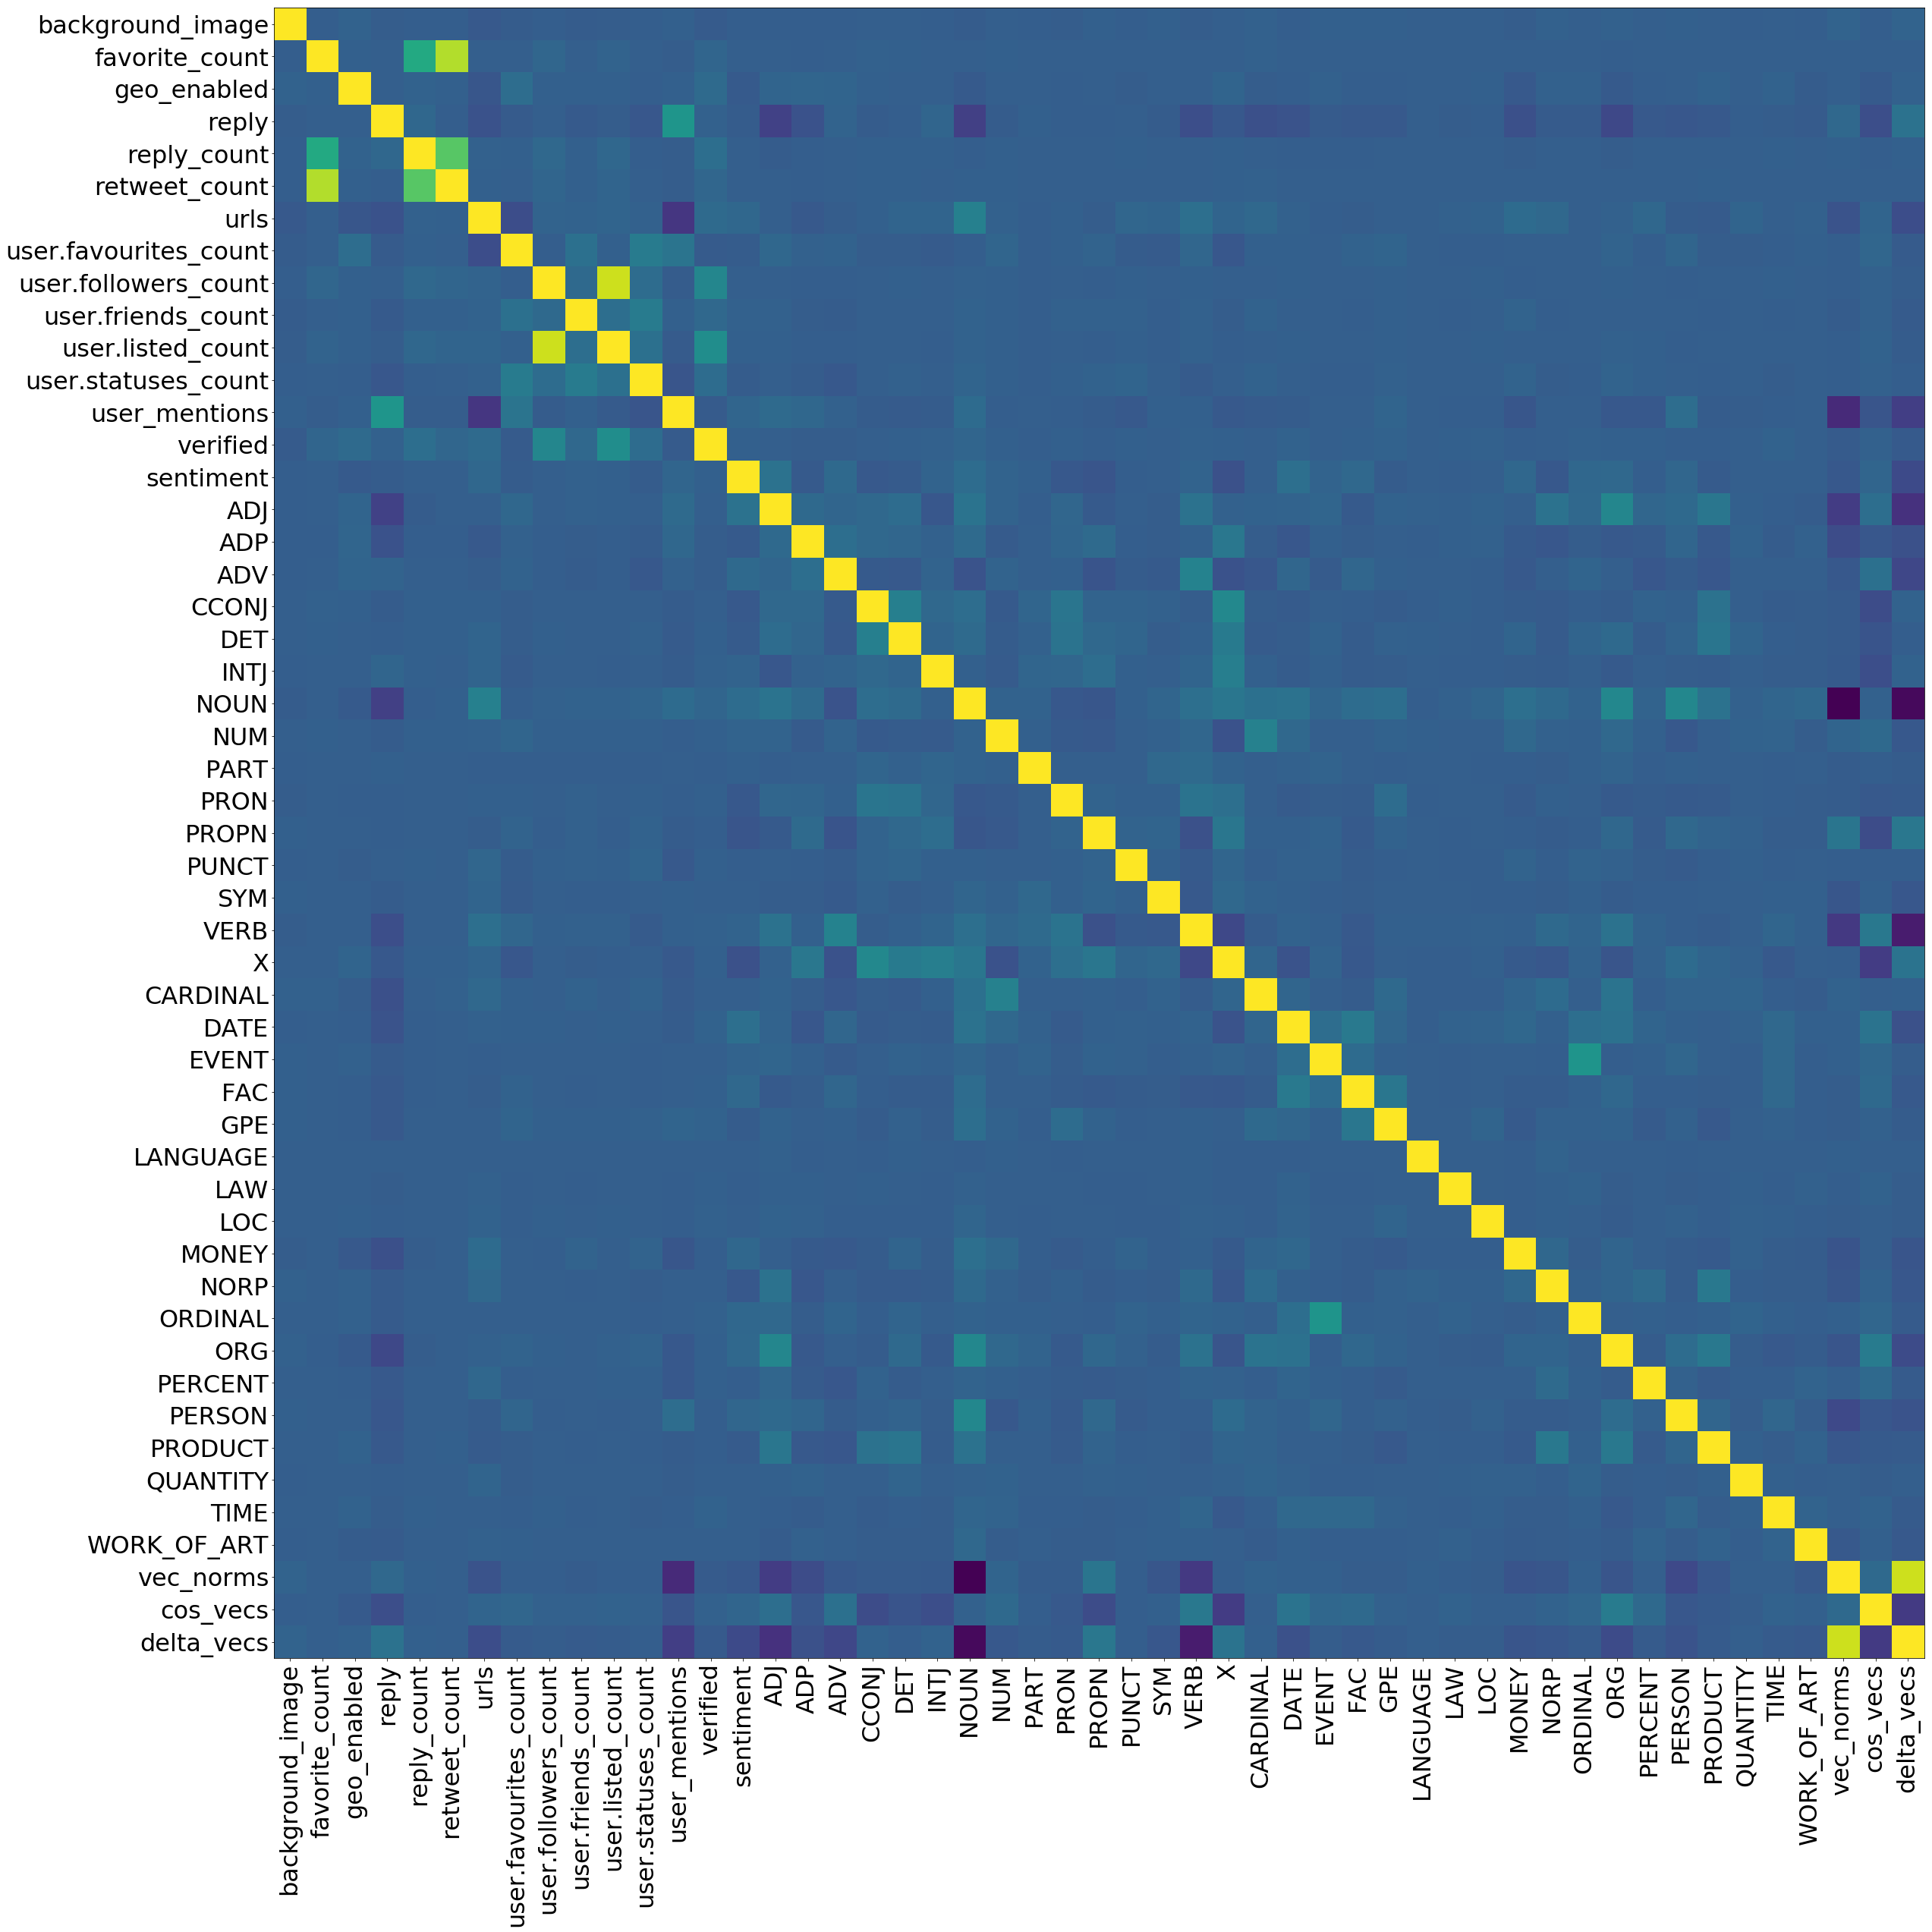

In [25]:
df_feature_corr,ax_corr = feature_correlation(df_features)

In [26]:
df_target_corr = feature_target_correlation(df_features)

In [27]:
df_target_corr.head()

,Target Correlation
108,0.206067
98,0.186251
190,0.171389
156,0.149589
137,0.128476


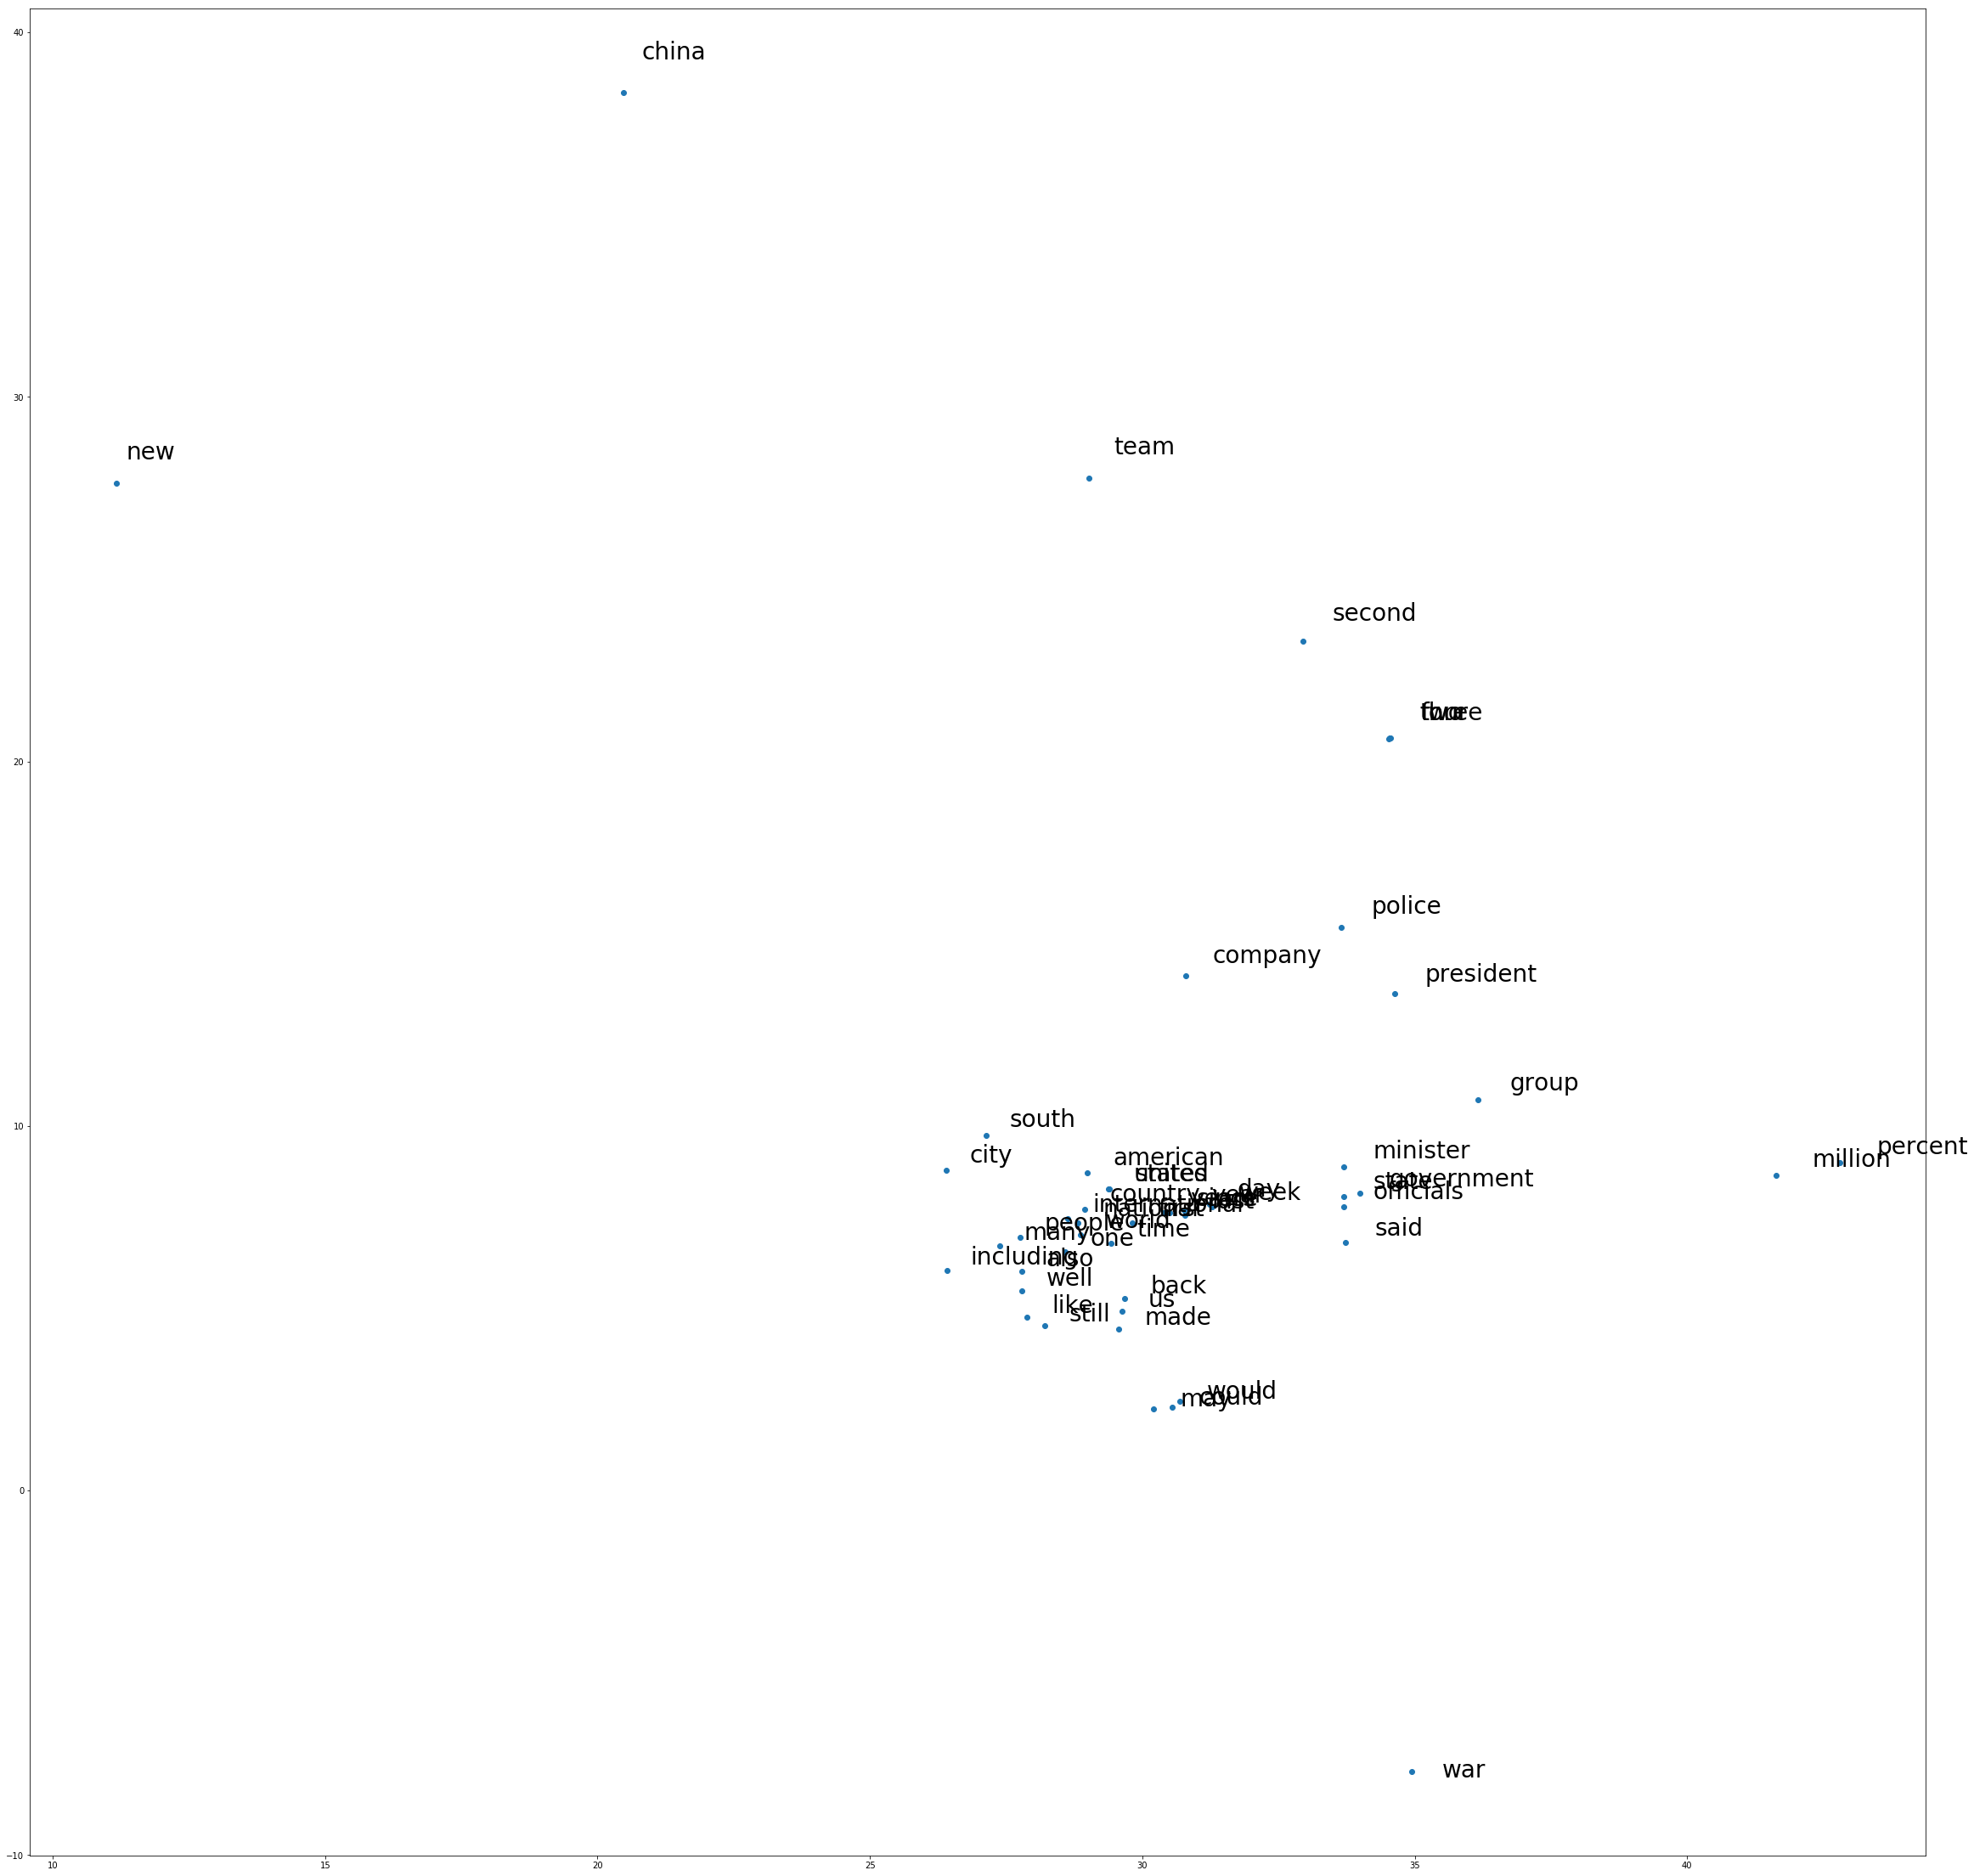

In [58]:
ax_text = word_plot(word_embeddings)

In [29]:
data = df_features.values

In [30]:
X = data[:,:-1]
Y = data[:,-1]

In [31]:
# Splits data into training and test sets.
xtr,xte,ytr,yte = train_test_split(X,Y,test_size=.2,stratify=Y)

In [32]:
xtr,x_val,ytr,y_val = train_test_split(xtr,ytr,test_size=.2)

In [33]:
ytr = ytr.astype(int)
y_val = y_val.astype(int)
yte = yte.astype(int)

In [34]:
param = {'max_depth': 5,'objective': 'binary:logistic'}
num_round = 1000
xgb_train = xgb.DMatrix(xtr,label=ytr)
xgb_test = xgb.DMatrix(xte,label=yte)
xgb_val = xgb.DMatrix(x_val,label=y_val)
evallist = [(xgb_val, 'eval'), (xgb_train, 'train')]
bst1 = xgb.train(param, xgb_train, num_round, evallist,early_stopping_rounds=10)
prediction_probabilities = bst1.predict(xgb_test,ntree_limit=bst1.best_ntree_limit)
predictions = np.array(list(map(np.round,prediction_probabilities)))
score = np.mean(predictions == yte)
print(score)

[0]	eval-error:0.306617	train-error:0.300658
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	eval-error:0.276577	train-error:0.272388
[2]	eval-error:0.265489	train-error:0.260444
[3]	eval-error:0.255265	train-error:0.246876
[4]	eval-error:0.24608	train-error:0.238002
[5]	eval-error:0.235069	train-error:0.226927
[6]	eval-error:0.226468	train-error:0.217064
[7]	eval-error:0.223474	train-error:0.213607
[8]	eval-error:0.220937	train-error:0.209332
[9]	eval-error:0.213477	train-error:0.203928
[10]	eval-error:0.207693	train-error:0.197984
[11]	eval-error:0.203633	train-error:0.19402
[12]	eval-error:0.202821	train-error:0.19213
[13]	eval-error:0.199193	train-error:0.187632
[14]	eval-error:0.196504	train-error:0.184822
[15]	eval-error:0.194195	train-error:0.181378
[16]	eval-error:0.192876	train-error:0.179951
[17]	eval-error:0.189907	train-error:0.17671
[18]	eval-error:0.186228	train-error:0.

[175]	eval-error:0.130233	train-error:0.081127
[176]	eval-error:0.130081	train-error:0.080835
[177]	eval-error:0.130284	train-error:0.080512
[178]	eval-error:0.129903	train-error:0.080201
[179]	eval-error:0.130055	train-error:0.080036
[180]	eval-error:0.129725	train-error:0.079827
[181]	eval-error:0.129928	train-error:0.079414
[182]	eval-error:0.129624	train-error:0.079066
[183]	eval-error:0.129599	train-error:0.078913
[184]	eval-error:0.129193	train-error:0.078761
[185]	eval-error:0.128888	train-error:0.07852
[186]	eval-error:0.128837	train-error:0.078292
[187]	eval-error:0.129218	train-error:0.077886
[188]	eval-error:0.129117	train-error:0.077581
[189]	eval-error:0.12904	train-error:0.07727
[190]	eval-error:0.128939	train-error:0.076757
[191]	eval-error:0.12904	train-error:0.076535
[192]	eval-error:0.128964	train-error:0.076275
[193]	eval-error:0.128939	train-error:0.076078
[194]	eval-error:0.128812	train-error:0.075996
[195]	eval-error:0.128837	train-error:0.075774
[196]	eval-error:

[351]	eval-error:0.122647	train-error:0.047173
[352]	eval-error:0.122672	train-error:0.047097
[353]	eval-error:0.122799	train-error:0.04683
[354]	eval-error:0.122799	train-error:0.046672
[355]	eval-error:0.122875	train-error:0.046456
[356]	eval-error:0.123027	train-error:0.046285
[357]	eval-error:0.122875	train-error:0.04619
[358]	eval-error:0.122647	train-error:0.046038
[359]	eval-error:0.122621	train-error:0.045879
[360]	eval-error:0.122266	train-error:0.045822
[361]	eval-error:0.122621	train-error:0.045765
[362]	eval-error:0.12252	train-error:0.045676
[363]	eval-error:0.122621	train-error:0.045644
[364]	eval-error:0.122621	train-error:0.045524
[365]	eval-error:0.122545	train-error:0.045372
[366]	eval-error:0.12252	train-error:0.045207
[367]	eval-error:0.122469	train-error:0.045156
[368]	eval-error:0.122292	train-error:0.04494
[369]	eval-error:0.122393	train-error:0.044858
[370]	eval-error:0.12252	train-error:0.044807
[371]	eval-error:0.122596	train-error:0.044725
[372]	eval-error:0.

[527]	eval-error:0.119881	train-error:0.030218
[528]	eval-error:0.119754	train-error:0.030129
[529]	eval-error:0.119602	train-error:0.02999
[530]	eval-error:0.119856	train-error:0.029971
[531]	eval-error:0.119881	train-error:0.029818
[532]	eval-error:0.120008	train-error:0.029844
[533]	eval-error:0.119577	train-error:0.029799
[534]	eval-error:0.119348	train-error:0.029679
[535]	eval-error:0.119551	train-error:0.029546
[536]	eval-error:0.11978	train-error:0.029584
[537]	eval-error:0.119831	train-error:0.029457
[538]	eval-error:0.119678	train-error:0.029463
[539]	eval-error:0.119729	train-error:0.029343
[540]	eval-error:0.119704	train-error:0.029324
[541]	eval-error:0.119704	train-error:0.029229
[542]	eval-error:0.11978	train-error:0.029102
[543]	eval-error:0.119348	train-error:0.028949
[544]	eval-error:0.119298	train-error:0.028968
[545]	eval-error:0.119374	train-error:0.028842
[546]	eval-error:0.119222	train-error:0.028708
[547]	eval-error:0.119171	train-error:0.028696
[548]	eval-error

[703]	eval-error:0.119019	train-error:0.0213
[704]	eval-error:0.119019	train-error:0.021319
[705]	eval-error:0.119247	train-error:0.0213
[706]	eval-error:0.11912	train-error:0.021211
[707]	eval-error:0.119196	train-error:0.021262
[708]	eval-error:0.118993	train-error:0.02123
[709]	eval-error:0.119019	train-error:0.021211
[710]	eval-error:0.118968	train-error:0.021205
[711]	eval-error:0.119145	train-error:0.021192
[712]	eval-error:0.11912	train-error:0.021014
[713]	eval-error:0.119145	train-error:0.020983
[714]	eval-error:0.118993	train-error:0.020957
[715]	eval-error:0.119019	train-error:0.020957
[716]	eval-error:0.118841	train-error:0.020983
[717]	eval-error:0.118892	train-error:0.020919
[718]	eval-error:0.118638	train-error:0.020843
[719]	eval-error:0.118663	train-error:0.020849
[720]	eval-error:0.118816	train-error:0.020843
[721]	eval-error:0.118943	train-error:0.020792
[722]	eval-error:0.118765	train-error:0.020754
[723]	eval-error:0.118613	train-error:0.020716
[724]	eval-error:0.1

In [35]:
print(classification_report(yte,predictions))

             precision    recall  f1-score   support

          0       0.88      0.87      0.88     23199
          1       0.89      0.90      0.89     26069

avg / total       0.89      0.89      0.89     49268



In [36]:
df_target_corr.loc[['vec_norms','delta_vecs']]

,Target Correlation
vec_norms,-0.0320954
delta_vecs,0.0106875


In [37]:
df_target_corr.loc[['retweet_count','favorite_count','reply_count']]

,Target Correlation
retweet_count,-0.000350467
favorite_count,4.41527e-06
reply_count,-0.00970407


In [38]:
df_target_corr.loc[['user.listed_count','user.followers_count']]

,Target Correlation
user.listed_count,0.000243856
user.followers_count,-0.00165546


In [48]:
df_dropped_features = df_features.drop(['vec_norms','reply_count','retweet_count','user.followers_count'],\
                                           axis=1)

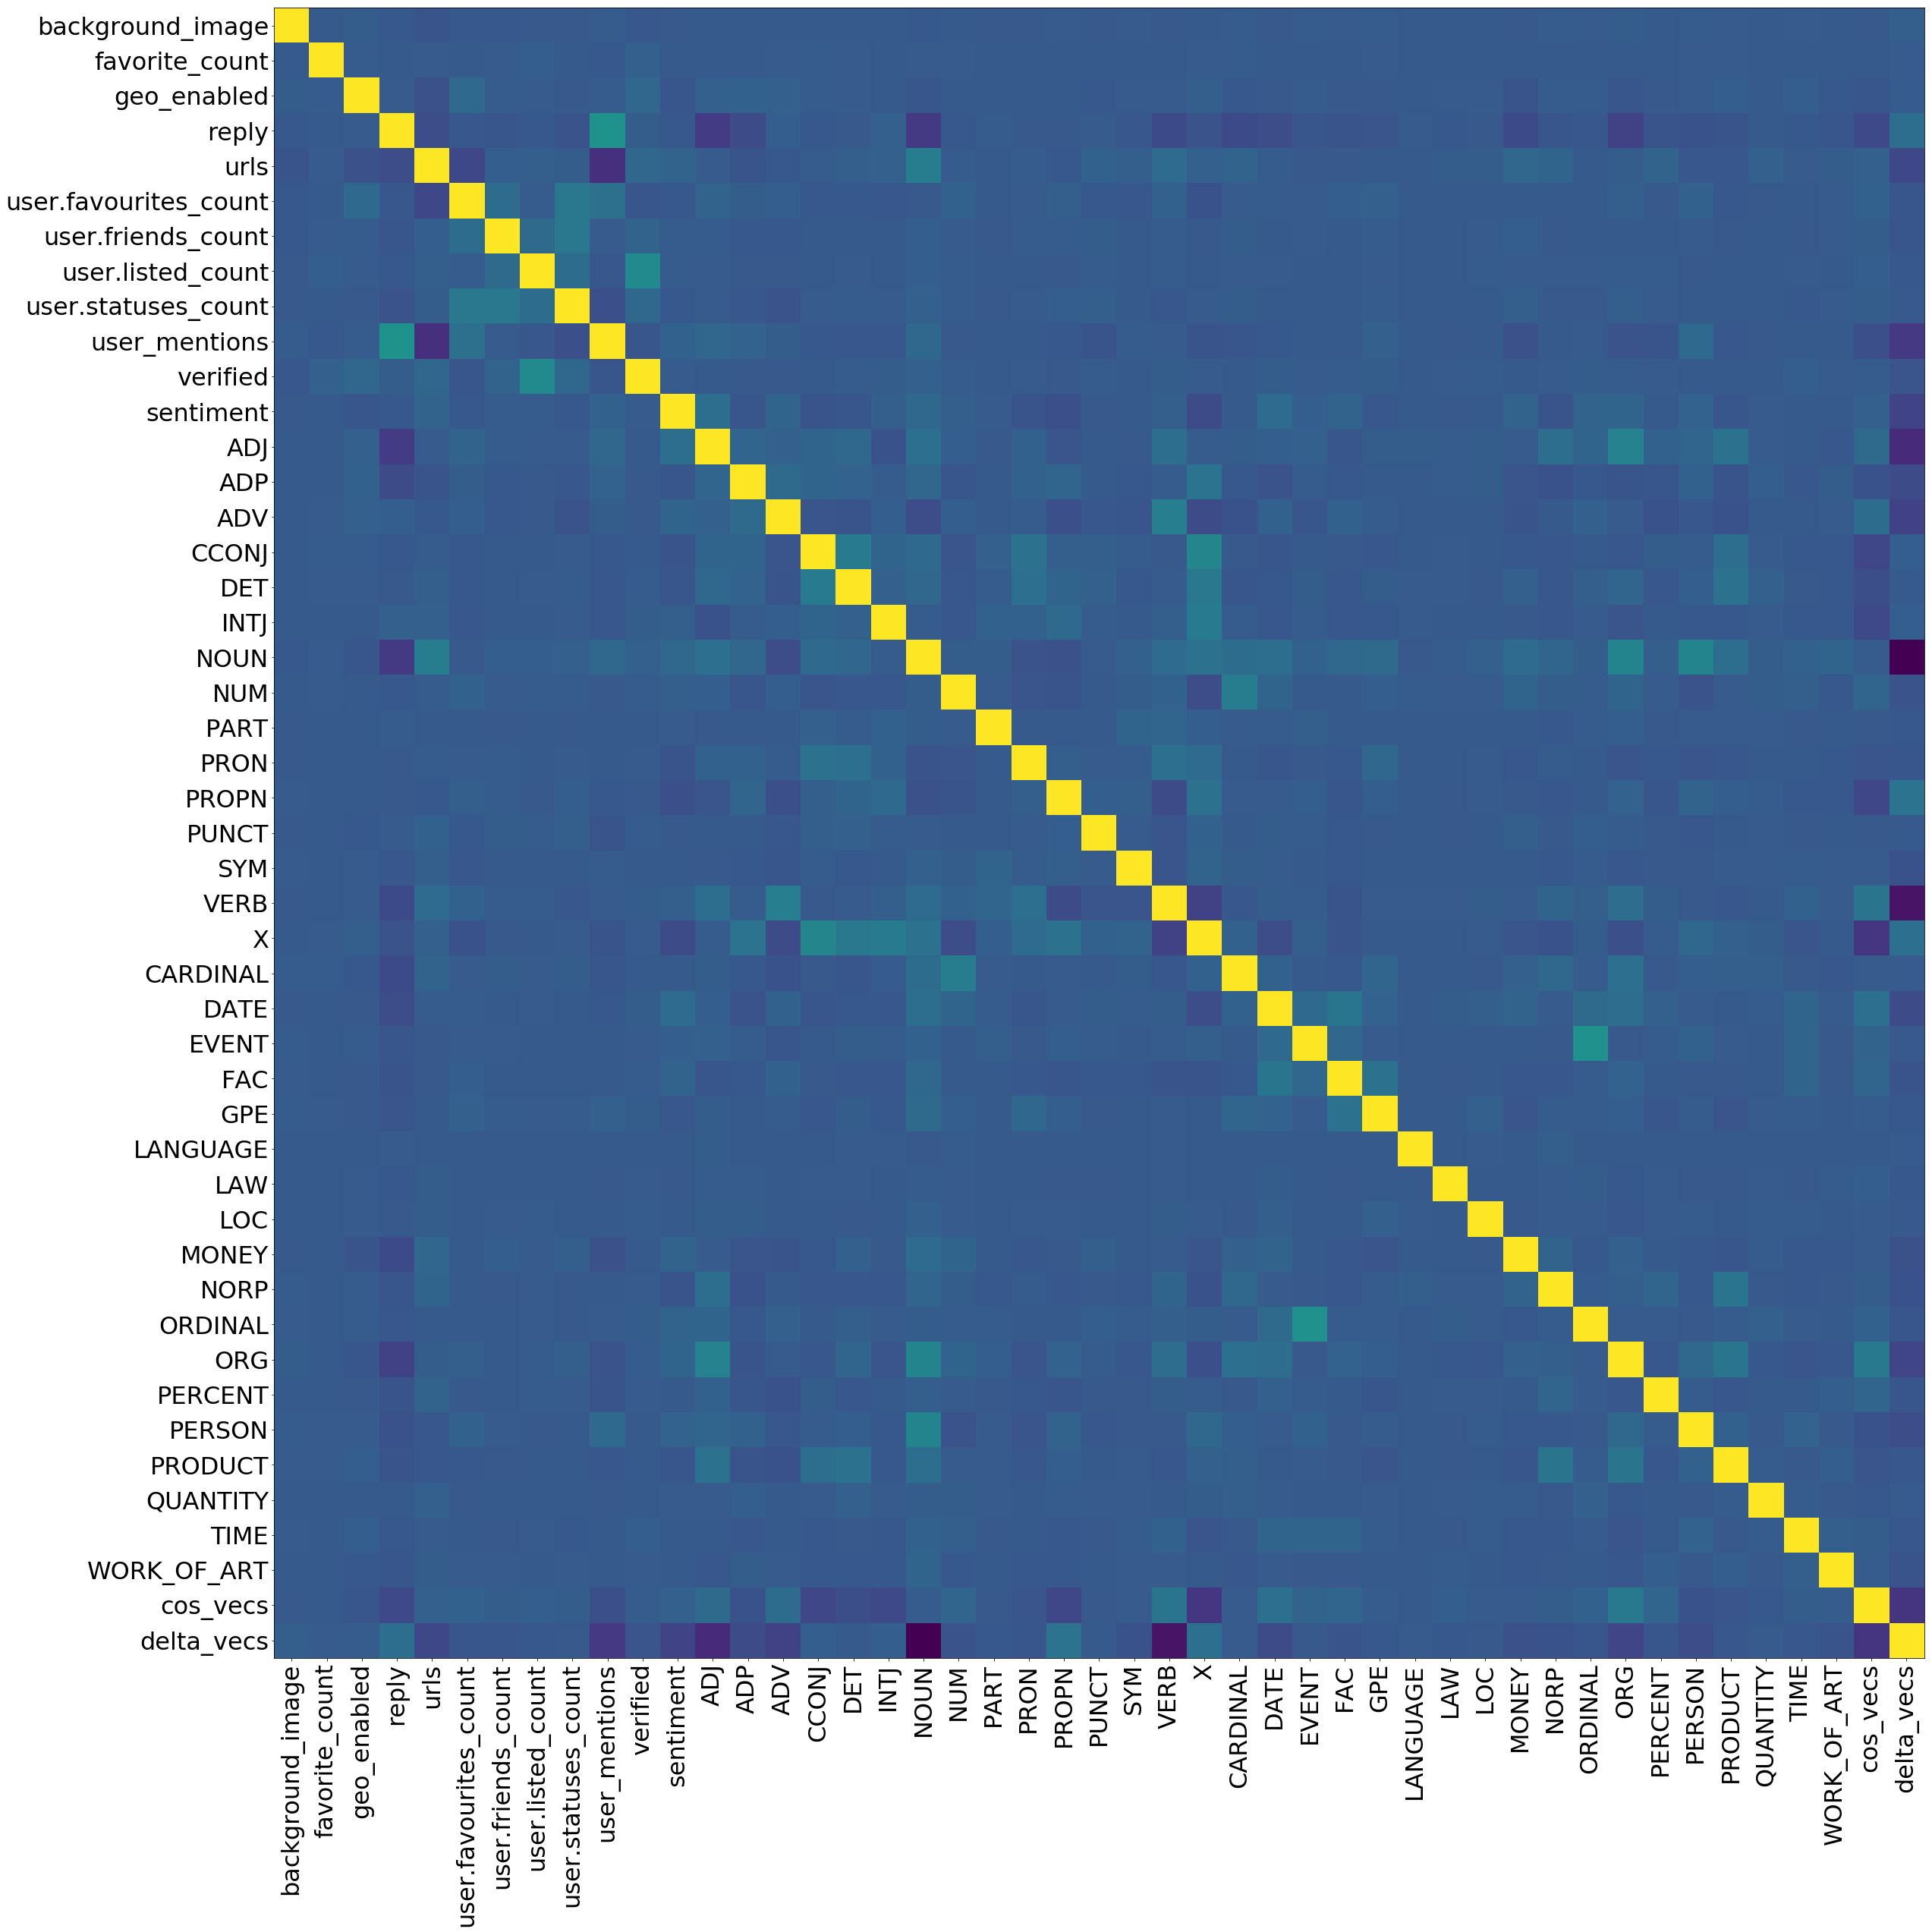

In [49]:
df_dropped_features_corr,ax_dropped_features_corr = feature_correlation(df_dropped_features)

In [50]:
data = df_dropped_features.values

In [51]:
X = data[:,:-1]
Y = data[:,-1]

In [52]:
# Splits data into training and test sets.
xtr,xte,ytr,yte = train_test_split(X,Y,test_size=.2,stratify=Y)

In [53]:
xtr,x_val,ytr,y_val = train_test_split(xtr,ytr,test_size=.2)

In [54]:
ytr = ytr.astype(int)
y_val = y_val.astype(int)
yte = yte.astype(int)

In [59]:
param = {'max_depth': 5,'objective': 'binary:logistic'}
num_round = 10000
xgb_train = xgb.DMatrix(xtr,label=ytr)
xgb_test = xgb.DMatrix(xte,label=yte)
xgb_val = xgb.DMatrix(x_val,label=y_val)
evallist = [(xgb_val, 'eval'), (xgb_train, 'train')]
bst2 = xgb.train(param, xgb_train, num_round, evallist,early_stopping_rounds=10)
prediction_probabilities = bst2.predict(xgb_test,ntree_limit=bst2.best_ntree_limit)
predictions = np.array(list(map(np.round,prediction_probabilities)))
score = np.mean(predictions == yte)
print(score)

[0]	eval-error:0.30309	train-error:0.305479
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	eval-error:0.28736	train-error:0.283336
[2]	eval-error:0.264322	train-error:0.26052
[3]	eval-error:0.252423	train-error:0.247904
[4]	eval-error:0.241792	train-error:0.238281
[5]	eval-error:0.231035	train-error:0.225786
[6]	eval-error:0.222205	train-error:0.216734
[7]	eval-error:0.216141	train-error:0.211254
[8]	eval-error:0.210763	train-error:0.206712
[9]	eval-error:0.206855	train-error:0.202418
[10]	eval-error:0.201223	train-error:0.196931
[11]	eval-error:0.199701	train-error:0.193398
[12]	eval-error:0.195819	train-error:0.189573
[13]	eval-error:0.192749	train-error:0.185844
[14]	eval-error:0.190567	train-error:0.183002
[15]	eval-error:0.188233	train-error:0.180294
[16]	eval-error:0.185645	train-error:0.176754
[17]	eval-error:0.184807	train-error:0.175168
[18]	eval-error:0.184478	train-error:0

[175]	eval-error:0.130715	train-error:0.080905
[176]	eval-error:0.131096	train-error:0.080575
[177]	eval-error:0.131197	train-error:0.080347
[178]	eval-error:0.131578	train-error:0.079973
[179]	eval-error:0.131578	train-error:0.079782
[180]	eval-error:0.131324	train-error:0.07937
[181]	eval-error:0.131172	train-error:0.079332
[182]	eval-error:0.131096	train-error:0.079211
[183]	eval-error:0.130537	train-error:0.078939
[184]	eval-error:0.130791	train-error:0.078577
[185]	eval-error:0.13074	train-error:0.078222
[186]	eval-error:0.130563	train-error:0.077721
[187]	eval-error:0.130334	train-error:0.077784
[188]	eval-error:0.13036	train-error:0.077645
[189]	eval-error:0.130284	train-error:0.077169
[190]	eval-error:0.130233	train-error:0.077061
[191]	eval-error:0.130588	train-error:0.076807
[192]	eval-error:0.130613	train-error:0.076573
[193]	eval-error:0.130487	train-error:0.076167
[194]	eval-error:0.130385	train-error:0.076065
[195]	eval-error:0.130182	train-error:0.07578
[196]	eval-error:

[351]	eval-error:0.1229	train-error:0.046919
[352]	eval-error:0.122748	train-error:0.046811
[353]	eval-error:0.122774	train-error:0.04671
[354]	eval-error:0.122621	train-error:0.046678
[355]	eval-error:0.122647	train-error:0.046665
[356]	eval-error:0.122748	train-error:0.046589
[357]	eval-error:0.122571	train-error:0.046431
[358]	eval-error:0.122723	train-error:0.046221
[359]	eval-error:0.122799	train-error:0.046152
[360]	eval-error:0.12285	train-error:0.046069
[361]	eval-error:0.122748	train-error:0.045942
[362]	eval-error:0.12252	train-error:0.045854
[363]	eval-error:0.122469	train-error:0.045828
[364]	eval-error:0.123053	train-error:0.045733
[365]	eval-error:0.12318	train-error:0.045606
[366]	eval-error:0.123205	train-error:0.045511
[367]	eval-error:0.123256	train-error:0.04546
[368]	eval-error:0.123154	train-error:0.045346
[369]	eval-error:0.123459	train-error:0.045111
[370]	eval-error:0.123484	train-error:0.045004
[371]	eval-error:0.123383	train-error:0.044826
[372]	eval-error:0.1

[527]	eval-error:0.120465	train-error:0.030091
[528]	eval-error:0.120617	train-error:0.029971
[529]	eval-error:0.120719	train-error:0.02992
[530]	eval-error:0.120795	train-error:0.029882
[531]	eval-error:0.120566	train-error:0.02985
[532]	eval-error:0.120338	train-error:0.029698
[533]	eval-error:0.120262	train-error:0.029711
[534]	eval-error:0.120262	train-error:0.029603
[535]	eval-error:0.120186	train-error:0.029539
[536]	eval-error:0.120566	train-error:0.029495
[537]	eval-error:0.120693	train-error:0.029476
[538]	eval-error:0.120414	train-error:0.029355
[539]	eval-error:0.120693	train-error:0.029178
[540]	eval-error:0.120566	train-error:0.029216
[541]	eval-error:0.120566	train-error:0.029197
[542]	eval-error:0.120338	train-error:0.029133
[543]	eval-error:0.120363	train-error:0.029121
[544]	eval-error:0.120338	train-error:0.029083
[545]	eval-error:0.120313	train-error:0.029057
[546]	eval-error:0.120389	train-error:0.029045
[547]	eval-error:0.120516	train-error:0.028968
[548]	eval-erro

[702]	eval-error:0.117953	train-error:0.021687
[703]	eval-error:0.117877	train-error:0.021668
[704]	eval-error:0.118029	train-error:0.02168
[705]	eval-error:0.118131	train-error:0.021655
[706]	eval-error:0.118029	train-error:0.02163
[707]	eval-error:0.117826	train-error:0.021585
[708]	eval-error:0.117801	train-error:0.021541
[709]	eval-error:0.117902	train-error:0.021452
[710]	eval-error:0.117877	train-error:0.021458
[711]	eval-error:0.117725	train-error:0.02137
[712]	eval-error:0.117572	train-error:0.021319
[713]	eval-error:0.117496	train-error:0.021319
[714]	eval-error:0.117801	train-error:0.021287
[715]	eval-error:0.117699	train-error:0.021255
[716]	eval-error:0.117801	train-error:0.021268
[717]	eval-error:0.117877	train-error:0.021249
[718]	eval-error:0.117572	train-error:0.021205
[719]	eval-error:0.117547	train-error:0.021192
[720]	eval-error:0.117674	train-error:0.02116
[721]	eval-error:0.117852	train-error:0.021192
[722]	eval-error:0.117725	train-error:0.021205
[723]	eval-error:

[878]	eval-error:0.117547	train-error:0.017862
[879]	eval-error:0.117446	train-error:0.017868
[880]	eval-error:0.117319	train-error:0.017792
[881]	eval-error:0.117344	train-error:0.017716
[882]	eval-error:0.117446	train-error:0.017729
[883]	eval-error:0.117268	train-error:0.017722
[884]	eval-error:0.117243	train-error:0.017754
[885]	eval-error:0.117192	train-error:0.017735
[886]	eval-error:0.117065	train-error:0.01771
[887]	eval-error:0.117319	train-error:0.017722
[888]	eval-error:0.117293	train-error:0.017691
[889]	eval-error:0.117192	train-error:0.01764
[890]	eval-error:0.117293	train-error:0.017659
[891]	eval-error:0.117395	train-error:0.017646
[892]	eval-error:0.117344	train-error:0.017627
[893]	eval-error:0.117116	train-error:0.017589
[894]	eval-error:0.117116	train-error:0.017576
[895]	eval-error:0.117141	train-error:0.017602
[896]	eval-error:0.117217	train-error:0.017615
[897]	eval-error:0.116811	train-error:0.017621
[898]	eval-error:0.116761	train-error:0.017621
[899]	eval-erro

[1052]	eval-error:0.116887	train-error:0.01528
[1053]	eval-error:0.116862	train-error:0.015204
[1054]	eval-error:0.116837	train-error:0.015185
[1055]	eval-error:0.116837	train-error:0.015185
[1056]	eval-error:0.116684	train-error:0.015172
[1057]	eval-error:0.116786	train-error:0.015153
[1058]	eval-error:0.116887	train-error:0.015109
[1059]	eval-error:0.116837	train-error:0.015109
[1060]	eval-error:0.116862	train-error:0.015096
[1061]	eval-error:0.116811	train-error:0.015084
[1062]	eval-error:0.116887	train-error:0.015065
[1063]	eval-error:0.117116	train-error:0.015033
[1064]	eval-error:0.116964	train-error:0.014982
[1065]	eval-error:0.116989	train-error:0.014957
[1066]	eval-error:0.116887	train-error:0.014963
[1067]	eval-error:0.116862	train-error:0.014925
[1068]	eval-error:0.116938	train-error:0.014982
[1069]	eval-error:0.116862	train-error:0.014957
[1070]	eval-error:0.116913	train-error:0.014989
[1071]	eval-error:0.116887	train-error:0.014957
[1072]	eval-error:0.116938	train-error:0.

In [60]:
print(classification_report(yte,predictions))

             precision    recall  f1-score   support

          0       0.88      0.87      0.88     23199
          1       0.89      0.90      0.89     26069

avg / total       0.89      0.89      0.89     49268



In [61]:
bst2.save_model('boost_model.bin')

In [62]:
xgb_train.save_binary('boost_train_data.bin')

In [63]:
xgb_test.save_binary('boost_test_data.bin')

In [64]:
xgb_val.save_binary('boost_val_data.bin')